In [43]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import xgboost as xgb
import shap
from pathlib import Path

# Load CSV - fix path since notebook is in machinelearning folder
csv_path = Path('industrial_2022toSep2025.csv')
df = pd.read_csv(csv_path)

# Quick preview
display(df.head())
df.info()


,ID,Month Year,Project Name,Street Name,Planning Area,Type of Sale,Price,$psm,Area,Tenure,...,Postal District,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25
0,50623,2022-12,FOOD VISION @ MANDAI,MANDAI ESTATE,Sungei Kadut,New Sale,"$2,570,000","$16,063",160,Freehold,...,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,50624,2022-12,E9 PREMIUM,WOODLANDS INDUSTRIAL PARK E9,Woodlands,Resale,"$620,000","$3,563",174,30 yrs from 28/10/2013,...,27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,50625,2022-12,FOOD VISION @ MANDAI,MANDAI ESTATE,Sungei Kadut,New Sale,"$2,283,000","$14,269",160,Freehold,...,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,50626,2022-12,MANDAI CONNECTION,MANDAI LINK,Sungei Kadut,Resale,"$510,000","$3,248",157,30 yrs from 20/11/2012,...,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,50627,2022-12,GEMINI @ SIMS,SIMS CLOSE,Geylang,Resale,"$2,950,000","$10,315",286,Freehold,...,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6866 entries, 0 to 6865
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               6866 non-null   int64  
 1   Month Year       6866 non-null   object 
 2   Project Name     6502 non-null   object 
 3   Street Name      6866 non-null   object 
 4   Planning Area    6866 non-null   object 
 5   Type of Sale     6866 non-null   object 
 6   Price            6866 non-null   object 
 7   $psm             6866 non-null   object 
 8   Area             6866 non-null   int64  
 9   Tenure           6866 non-null   object 
 10  Contract Date    6866 non-null   object 
 11  Property Type    6866 non-null   object 
 12  Type Of Area     6866 non-null   object 
 13  Floor Level      6866 non-null   object 
 14  Region           6866 non-null   object 
 15  Postal Sector    6866 non-null   int64  
 16  Postal District  6866 non-null   int64  
 17  Unnamed: 17   

In [44]:
# Basic cleaning: normalize columns and numeric fields

df.columns = [c.strip().lower().replace(' ', '_').replace('/', '_') for c in df.columns]

# Strip currency and commas from price and $psm; ensure numeric
for col in ['price', '$psm', 'area']:
    if col in df.columns:
        df[col] = (
            df[col]
            .astype(str)
            .str.replace('$', '', regex=False)
            .str.replace(',', '', regex=False)
            .str.strip()
        )
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Parse dates
for col in ['contract_date', 'month_year']:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

# Drop obvious null rows in essential fields
essential = [c for c in ['price', '$psm', 'area', 'property_type', 'planning_area'] if c in df.columns]
df = df.dropna(subset=essential)

display(df.head())
df.describe(include='all')


,id,month_year,project_name,street_name,planning_area,type_of_sale,price,$psm,area,tenure,...,postal_district,unnamed:_17,unnamed:_18,unnamed:_19,unnamed:_20,unnamed:_21,unnamed:_22,unnamed:_23,unnamed:_24,unnamed:_25
0,50623,2022-12-01,FOOD VISION @ MANDAI,MANDAI ESTATE,Sungei Kadut,New Sale,2570000,16063,160,Freehold,...,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,50624,2022-12-01,E9 PREMIUM,WOODLANDS INDUSTRIAL PARK E9,Woodlands,Resale,620000,3563,174,30 yrs from 28/10/2013,...,27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,50625,2022-12-01,FOOD VISION @ MANDAI,MANDAI ESTATE,Sungei Kadut,New Sale,2283000,14269,160,Freehold,...,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,50626,2022-12-01,MANDAI CONNECTION,MANDAI LINK,Sungei Kadut,Resale,510000,3248,157,30 yrs from 20/11/2012,...,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,50627,2022-12-01,GEMINI @ SIMS,SIMS CLOSE,Geylang,Resale,2950000,10315,286,Freehold,...,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,id,month_year,project_name,street_name,planning_area,type_of_sale,price,$psm,area,tenure,...,postal_district,unnamed:_17,unnamed:_18,unnamed:_19,unnamed:_20,unnamed:_21,unnamed:_22,unnamed:_23,unnamed:_24,unnamed:_25
count,6866.000000,6866,6502,6866,6866,6866,6.866000e+03,6866.000000,6866.000000,6866,...,6866.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
unique,NaN,NaN,339,273,27,3,NaN,NaN,NaN,423,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,MIDVIEW CITY,WOODLANDS CLOSE,Geylang,Resale,NaN,NaN,NaN,Freehold,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,173,380,1263,6592,NaN,NaN,NaN,1061,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,69339.656714,2023-09-30 19:00:05.243227392,NaN,NaN,NaN,NaN,2.015456e+06,5450.182785,626.167055,NaN,...,19.260268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,43726.000000,2022-01-01 00:00:00,NaN,NaN,NaN,NaN,3.000000e+04,102.000000,19.000000,NaN,...,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,50775.250000,2022-10-01 00:00:00,NaN,NaN,NaN,NaN,6.220000e+05,3214.000000,135.000000,NaN,...,14.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,65875.500000,2023-10-01 00:00:00,NaN,NaN,NaN,NaN,8.900000e+05,4886.500000,173.000000,NaN,...,22.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,93651.750000,2024-09-01 00:00:00,NaN,NaN,NaN,NaN,1.420750e+06,6647.500000,286.000000,NaN,...,25.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,98225.000000,2025-09-01 00:00:00,NaN,NaN,NaN,NaN,1.420000e+08,39150.000000,139073.000000,NaN,...,27.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
# ML Pipeline & Prediction Engine

from dataclasses import dataclass
from typing import Optional, Dict, List
import warnings
warnings.filterwarnings('ignore')

@dataclass
class Metrics:
    estimated_sales_price: Optional[float]
    estimated_rental_price: Optional[float]
    market_trend_pct_12m: Optional[float]
    median_sale_price: Optional[float]
    highest_sold_price: Optional[float]
    similar_transactions: Optional[pd.DataFrame] = None


class PropertyPricePredictor:
    def __init__(self, df: pd.DataFrame):
        self.df = df.copy()
        self.model = None
        self.preprocessor = None
        self.feature_columns = None
        
    def prepare_features(self):
        """Prepare features for ML model"""
        # Create feature columns
        feature_cols = ['area', 'planning_area', 'property_type', 'type_of_sale', 'tenure', 'floor_level']
        
        # Convert categorical to numeric
        df_ml = self.df.copy()
        
        # Extract numeric features
        if 'area' in df_ml.columns:
            df_ml['area'] = pd.to_numeric(df_ml['area'], errors='coerce')
        
        # One-hot encode categorical features
        categorical_features = ['planning_area', 'property_type', 'type_of_sale', 'tenure', 'floor_level']
        categorical_features = [col for col in categorical_features if col in df_ml.columns]
        
        if categorical_features:
            encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
            encoded = encoder.fit_transform(df_ml[categorical_features].fillna('Unknown'))
            encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(categorical_features))
            df_ml = pd.concat([df_ml[['area']], encoded_df], axis=1)
        
        # Add time features
        if 'contract_date' in df_ml.columns:
            df_ml['year'] = pd.to_datetime(df_ml['contract_date']).dt.year
            df_ml['month'] = pd.to_datetime(df_ml['contract_date']).dt.month
            df_ml['quarter'] = pd.to_datetime(df_ml['contract_date']).dt.quarter
        
        self.feature_columns = df_ml.columns.tolist()
        return df_ml
    
    def train_model(self):
        """Train XGBoost model for price prediction using advanced ML pipeline"""
        # Prepare features using ColumnTransformer and Pipeline
        feature_cols = ['area', 'planning_area', 'property_type', 'type_of_sale', 'tenure', 'floor_level']
        X = self.df[feature_cols].copy()
        y = pd.to_numeric(self.df['price'], errors='coerce')
        
        # Remove rows with missing target
        valid_idx = ~y.isna()
        X = X[valid_idx]
        y = y[valid_idx]
        
        if len(X) < 10:  # Need minimum data
            return False
        
        # Define categorical and numerical features
        categorical_features = ['planning_area', 'property_type', 'type_of_sale', 'tenure', 'floor_level']
        numerical_features = ['area']
        
        # Create preprocessing pipeline using ColumnTransformer
        self.preprocessor = ColumnTransformer([
            ('num', 'passthrough', numerical_features),
            ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features)
        ])
        
        # Create full ML pipeline
        self.model = Pipeline([
            ('preprocessor', self.preprocessor),
            ('regressor', xgb.XGBRegressor(
                n_estimators=200,
                max_depth=6,
                learning_rate=0.1,
                random_state=42
            ))
        ])
        
        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Train the pipeline
        self.model.fit(X_train, y_train)
        
        # Evaluate
        train_score = self.model.score(X_train, y_train)
        test_score = self.model.score(X_test, y_test)
        
        print(f"Advanced ML Pipeline trained - Train R²: {train_score:.3f}, Test R²: {test_score:.3f}")
        
        # Store test data for SHAP analysis
        self.X_test = X_test
        self.y_test = y_test
        
        return True
    
    def explain_prediction(self, area: float, planning_area: str, property_type: str, 
                          type_of_sale: str = "Resale", tenure: str = "99-year leasehold", 
                          floor_level: str = "Non-First Floor"):
        """Explain prediction using SHAP values"""
        if self.model is None:
            print("Model not trained yet!")
            return None
            
        # Create input for explanation
        input_data = pd.DataFrame({
            'area': [area],
            'planning_area': [planning_area],
            'property_type': [property_type],
            'type_of_sale': [type_of_sale],
            'tenure': [tenure],
            'floor_level': [floor_level]
        })
        
        # Get the XGBoost model from the pipeline
        xgb_model = self.model.named_steps['regressor']
        
        # Transform the input data using the preprocessor
        X_transformed = self.model.named_steps['preprocessor'].transform(input_data)
        
        # Create SHAP explainer
        explainer = shap.TreeExplainer(xgb_model)
        shap_values = explainer.shap_values(X_transformed)
        
        # Get feature names
        feature_names = self.model.named_steps['preprocessor'].get_feature_names_out()
        
        # Create SHAP explanation
        print(f"🔍 SHAP Explanation for Prediction:")
        print(f"Input: {area} sqm, {planning_area}, {property_type}")
        print(f"Predicted Price: ${self.predict_price(area, planning_area, property_type, type_of_sale, tenure, floor_level):,.0f}")
        print(f"\nFeature Importance (SHAP values):")
        
        # Show top contributing features
        feature_importance = pd.DataFrame({
            'feature': feature_names,
            'shap_value': shap_values[0]
        }).sort_values('shap_value', key=abs, ascending=False)
        
        for _, row in feature_importance.head(10).iterrows():
            direction = "📈" if row['shap_value'] > 0 else "📉"
            print(f"{direction} {row['feature']}: {row['shap_value']:+.2f}")
        
        return shap_values
    
    def predict_price(self, area: float, planning_area: str, property_type: str, 
                     type_of_sale: str = "Resale", tenure: str = "99-year leasehold", 
                     floor_level: str = "Non-First Floor") -> Optional[float]:
        """Predict price for given features using the trained pipeline"""
        if self.model is None:
            return None
            
        # Create input dataframe with same structure as training data
        input_data = pd.DataFrame({
            'area': [area],
            'planning_area': [planning_area],
            'property_type': [property_type],
            'type_of_sale': [type_of_sale],
            'tenure': [tenure],
            'floor_level': [floor_level]
        })
        
        # Use the trained pipeline to predict
        prediction = self.model.predict(input_data)[0]
        return float(prediction) if not np.isnan(prediction) else None


def compute_metrics_for(planning_area: str, property_type: str, target_area: Optional[float]=None) -> Metrics:
    """Compute comprehensive metrics using ML model"""
    scope = df.copy()
    if 'planning_area' in scope.columns:
        scope = scope[scope['planning_area'].str.lower() == planning_area.lower()]
    if 'property_type' in scope.columns:
        scope = scope[scope['property_type'].str.lower() == property_type.lower()]
    
    # Basic statistics
    median_price = float(scope['price'].median()) if not scope.empty and 'price' in scope.columns else None
    highest_price = float(scope['price'].max()) if not scope.empty and 'price' in scope.columns else None
    
    # Market trend (12-month)
    trend = None
    if not scope.empty and 'contract_date' in scope.columns:
        scope['contract_date'] = pd.to_datetime(scope['contract_date'], errors='coerce')
        scope = scope.dropna(subset=['contract_date'])
        if len(scope) > 1:
            recent = scope[scope['contract_date'] >= scope['contract_date'].max() - pd.Timedelta(days=365)]
            older = scope[scope['contract_date'] < scope['contract_date'].max() - pd.Timedelta(days=365)]
            if len(recent) > 0 and len(older) > 0:
                recent_median = recent['price'].median()
                older_median = older['price'].median()
                if older_median > 0:
                    trend = float((recent_median - older_median) / older_median * 100)
    
    # ML-based price prediction
    predictor = PropertyPricePredictor(df)
    if predictor.train_model() and target_area:
        estimated_sales = predictor.predict_price(
            area=target_area,
            planning_area=planning_area,
            property_type=property_type
        )
        # Rental estimate: 5% annual yield / 12 months
        estimated_rental = estimated_sales * 0.05 / 12 if estimated_sales else None
    else:
        # Fallback to simple estimation
        if not scope.empty and '$psm' in scope.columns:
            psm_median = scope['$psm'].median()
            estimated_sales = float(psm_median * target_area) if target_area else None
            estimated_rental = estimated_sales * 0.05 / 12 if estimated_sales else None
        else:
            estimated_sales = None
            estimated_rental = None
    
    # Similar transactions
    similar = scope.sort_values('contract_date', ascending=False).head(10)[[
        'project_name','street_name','planning_area','price','$psm','area','contract_date','property_type','floor_level'
    ]].reset_index(drop=True) if not scope.empty else None
    
    return Metrics(
        estimated_sales_price=estimated_sales,
        estimated_rental_price=estimated_rental,
        market_trend_pct_12m=trend,
        median_sale_price=median_price,
        highest_sold_price=highest_price,
        similar_transactions=similar
    )


In [46]:
# Example run with Advanced ML Pipeline + SHAP Explainability
example_planning_area = 'Woodlands'
example_property_type = 'Multiple-User Factory'
example_area = 150.0  # sq m (CSV Area is likely sqm)

print(f"🏭 ADVANCED ML PREDICTION: {example_planning_area} - {example_property_type} ({example_area} sqm)")
print("="*70)

metrics = compute_metrics_for(example_planning_area, example_property_type, example_area)

print(f"Estimated Sales Price: ${metrics.estimated_sales_price:,.0f}" if metrics.estimated_sales_price else "Estimated Sales Price: N/A")
print(f"Estimated Rental Price: ${metrics.estimated_rental_price:,.0f}/month" if metrics.estimated_rental_price else "Estimated Rental Price: N/A")
print(f"Market Trend (12m): {metrics.market_trend_pct_12m:+.1f}%" if metrics.market_trend_pct_12m else "Market Trend: N/A")
print(f"Median Sale Price: ${metrics.median_sale_price:,.0f}" if metrics.median_sale_price else "Median Sale Price: N/A")
print(f"Highest Sold Price: ${metrics.highest_sold_price:,.0f}" if metrics.highest_sold_price else "Highest Sold Price: N/A")

# SHAP Explanation
print(f"\n{'='*70}")
print("🔍 SHAP EXPLAINABILITY ANALYSIS")
print("="*70)

# Create predictor and get SHAP explanation
predictor = PropertyPricePredictor(df)
if predictor.train_model():
    shap_values = predictor.explain_prediction(
        area=example_area,
        planning_area=example_planning_area,
        property_type=example_property_type
    )

if metrics.similar_transactions is not None and not metrics.similar_transactions.empty:
    print(f"\n📊 SIMILAR TRANSACTIONS ({len(metrics.similar_transactions)} found):")
    print("="*50)
    display(metrics.similar_transactions.head())
else:
    print("\nNo similar transactions found")


🏭 ADVANCED ML PREDICTION: Woodlands - Multiple-User Factory (150.0 sqm)
Advanced ML Pipeline trained - Train R²: 0.984, Test R²: 0.398
Estimated Sales Price: $698,909
Estimated Rental Price: $2,912/month
Market Trend (12m): +16.8%
Median Sale Price: $710,000
Highest Sold Price: $135,200,000

🔍 SHAP EXPLAINABILITY ANALYSIS
Advanced ML Pipeline trained - Train R²: 0.984, Test R²: 0.398
🔍 SHAP Explanation for Prediction:
Input: 150.0 sqm, Woodlands, Multiple-User Factory
Predicted Price: $698,909

Feature Importance (SHAP values):
📉 num__area: -1358459.00
📈 cat__property_type_Single-User Factory: +221017.36
📉 cat__tenure_Freehold: -173478.62
📉 cat__floor_level_-: -99284.02
📈 cat__property_type_Multiple-User Factory: +81715.51
📈 cat__planning_area_Tuas: +34482.86
📉 cat__planning_area_Bukit Merah: -28277.20
📈 cat__planning_area_Pioneer: +24893.31
📉 cat__planning_area_Geylang: -18263.78
📈 cat__planning_area_Woodlands: +14600.72

📊 SIMILAR TRANSACTIONS (10 found):


,project_name,street_name,planning_area,price,$psm,area,contract_date,property_type,floor_level
0,ADMIRALTY INDUSTRIAL PARK,WOODLANDS INDUSTRIAL PARK E1,Woodlands,500000,5747,87,2025-12-03,Multiple-User Factory,First Floor
1,MEGA@WOODLANDS,WOODLANDS CLOSE,Woodlands,462000,2655,174,2025-12-02,Multiple-User Factory,Non-First Floor
2,HARVEST @ WOODLANDS,WOODLANDS INDUSTRIAL PARK E5,Woodlands,728888,4733,154,2025-11-08,Multiple-User Factory,Non-First Floor
3,ADMIRALTY INDUSTRIAL PARK,WOODLANDS INDUSTRIAL PARK E1,Woodlands,420000,4773,88,2025-11-02,Multiple-User Factory,Non-First Floor
4,E9 PREMIUM,WOODLANDS INDUSTRIAL PARK E9,Woodlands,750000,2168,346,2025-10-06,Multiple-User Factory,Non-First Floor


🏭 INDUSTRIAL PROPERTY MARKET TRENDS


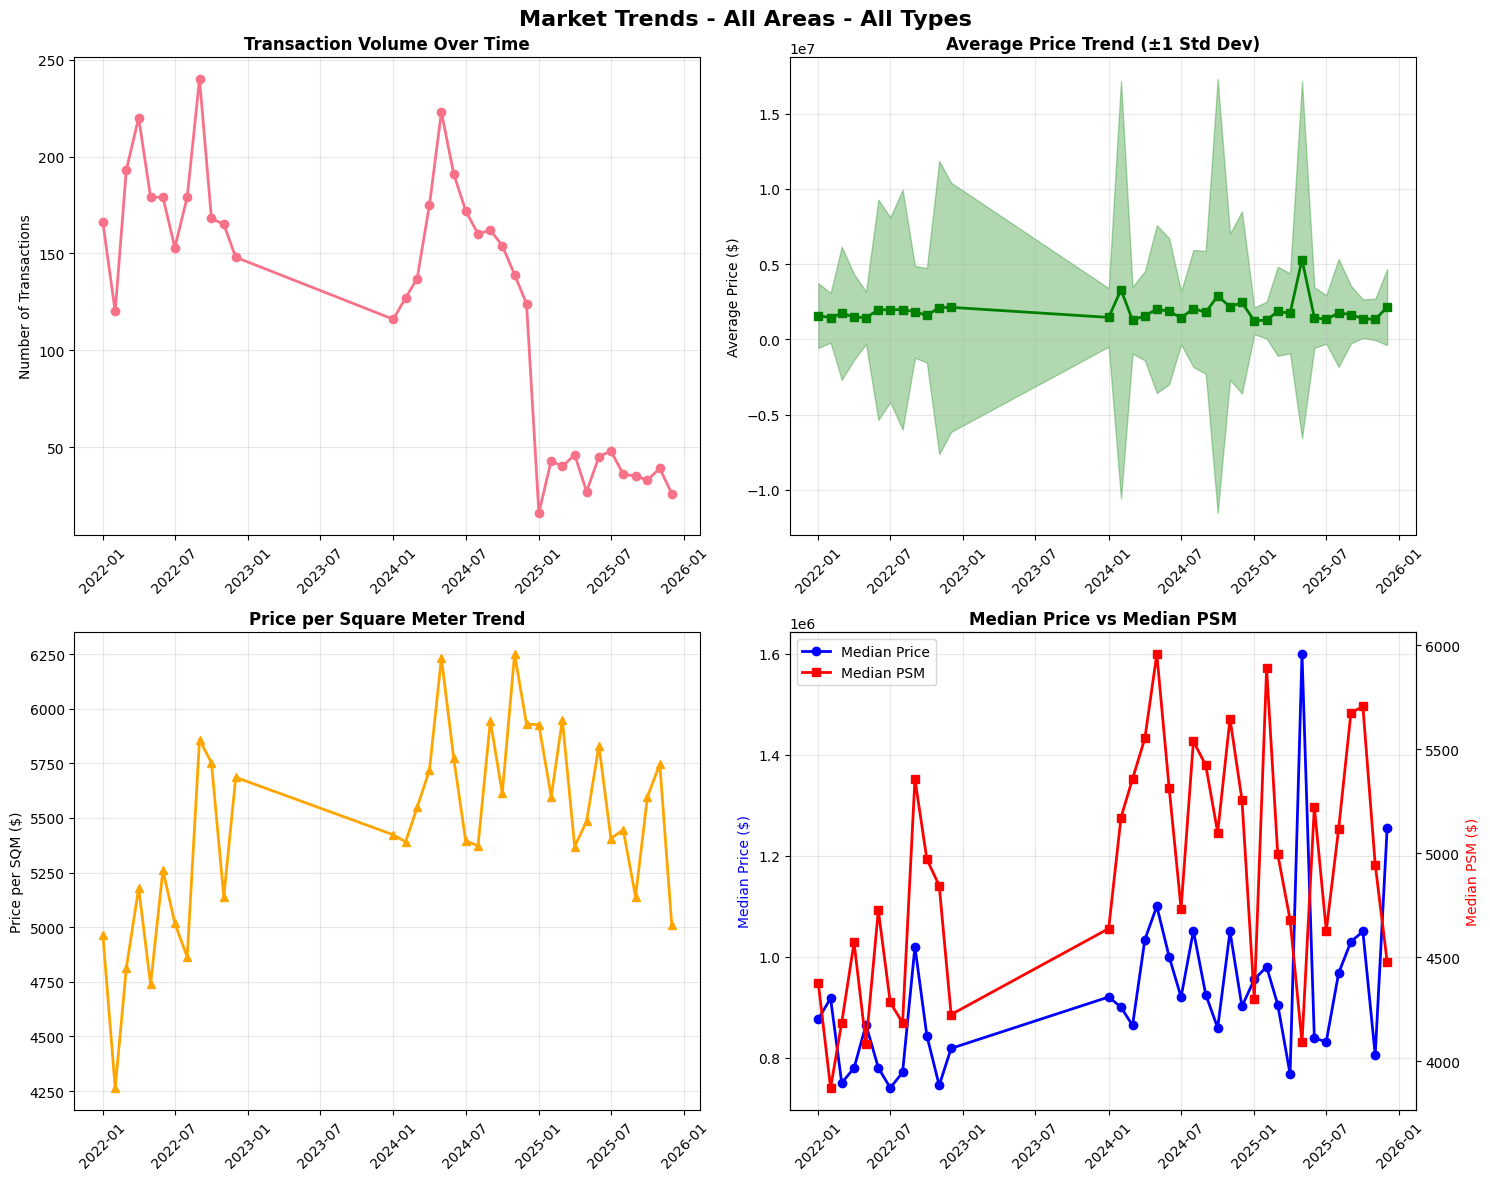


📊 SUMMARY STATISTICS
Total Transactions: 4,424
Date Range: 2022-01 to 2025-12
Average Price: $1,862,906
Median Price: $890,000
Average PSM: $5,444
Median PSM: $4,860
Year-over-Year Growth: -12.7%


In [47]:
# -------------------------
# TREND VISUALIZATION
# -------------------------
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

# Create trend analysis
def plot_market_trends(df, planning_area=None, property_type=None):
    """Plot market trends over time"""
    
    # Filter data if specific area/type requested
    trend_df = df.copy()
    if planning_area:
        trend_df = trend_df[trend_df['planning_area'].str.lower() == planning_area.lower()]
    if property_type:
        trend_df = trend_df[trend_df['property_type'].str.lower() == property_type.lower()]
    
    # Convert contract_date to datetime
    trend_df['contract_date'] = pd.to_datetime(trend_df['contract_date'], errors='coerce')
    trend_df = trend_df.dropna(subset=['contract_date'])
    
    # Group by month and calculate statistics
    monthly_stats = trend_df.groupby(trend_df['contract_date'].dt.to_period('M')).agg({
        'price': ['count', 'mean', 'median', 'std'],
        '$psm': ['mean', 'median']
    }).round(2)
    
    # Flatten column names
    monthly_stats.columns = ['_'.join(col).strip() for col in monthly_stats.columns]
    monthly_stats = monthly_stats.reset_index()
    monthly_stats['contract_date'] = monthly_stats['contract_date'].dt.to_timestamp()
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'Market Trends - {planning_area or "All Areas"} - {property_type or "All Types"}', 
                 fontsize=16, fontweight='bold')
    
    # 1. Transaction Volume
    axes[0,0].plot(monthly_stats['contract_date'], monthly_stats['price_count'], 
                   marker='o', linewidth=2, markersize=6)
    axes[0,0].set_title('Transaction Volume Over Time', fontweight='bold')
    axes[0,0].set_ylabel('Number of Transactions')
    axes[0,0].grid(True, alpha=0.3)
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # 2. Average Price Trend
    axes[0,1].plot(monthly_stats['contract_date'], monthly_stats['price_mean'], 
                   marker='s', linewidth=2, markersize=6, color='green')
    axes[0,1].fill_between(monthly_stats['contract_date'], 
                          monthly_stats['price_mean'] - monthly_stats['price_std'],
                          monthly_stats['price_mean'] + monthly_stats['price_std'],
                          alpha=0.3, color='green')
    axes[0,1].set_title('Average Price Trend (±1 Std Dev)', fontweight='bold')
    axes[0,1].set_ylabel('Average Price ($)')
    axes[0,1].grid(True, alpha=0.3)
    axes[0,1].tick_params(axis='x', rotation=45)
    
    # 3. Price per Square Meter
    axes[1,0].plot(monthly_stats['contract_date'], monthly_stats['$psm_mean'], 
                   marker='^', linewidth=2, markersize=6, color='orange')
    axes[1,0].set_title('Price per Square Meter Trend', fontweight='bold')
    axes[1,0].set_ylabel('Price per SQM ($)')
    axes[1,0].grid(True, alpha=0.3)
    axes[1,0].tick_params(axis='x', rotation=45)
    
    # 4. Median Price vs Median PSM
    ax2 = axes[1,1].twinx()
    line1 = axes[1,1].plot(monthly_stats['contract_date'], monthly_stats['price_median'], 
                          marker='o', linewidth=2, markersize=6, color='blue', label='Median Price')
    line2 = ax2.plot(monthly_stats['contract_date'], monthly_stats['$psm_median'], 
                    marker='s', linewidth=2, markersize=6, color='red', label='Median PSM')
    
    axes[1,1].set_title('Median Price vs Median PSM', fontweight='bold')
    axes[1,1].set_ylabel('Median Price ($)', color='blue')
    ax2.set_ylabel('Median PSM ($)', color='red')
    axes[1,1].grid(True, alpha=0.3)
    axes[1,1].tick_params(axis='x', rotation=45)
    
    # Combine legends
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    axes[1,1].legend(lines, labels, loc='upper left')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\n📊 SUMMARY STATISTICS")
    print(f"{'='*50}")
    print(f"Total Transactions: {len(trend_df):,}")
    print(f"Date Range: {trend_df['contract_date'].min().strftime('%Y-%m')} to {trend_df['contract_date'].max().strftime('%Y-%m')}")
    print(f"Average Price: ${trend_df['price'].mean():,.0f}")
    print(f"Median Price: ${trend_df['price'].median():,.0f}")
    print(f"Average PSM: ${trend_df['$psm'].mean():,.0f}")
    print(f"Median PSM: ${trend_df['$psm'].median():,.0f}")
    
    # Calculate year-over-year growth
    if len(monthly_stats) >= 12:
        latest_avg = monthly_stats['price_mean'].iloc[-1]
        year_ago_avg = monthly_stats['price_mean'].iloc[-13] if len(monthly_stats) >= 13 else monthly_stats['price_mean'].iloc[0]
        yoy_growth = ((latest_avg - year_ago_avg) / year_ago_avg) * 100
        print(f"Year-over-Year Growth: {yoy_growth:+.1f}%")
    
    return monthly_stats

# Plot overall market trends
print("🏭 INDUSTRIAL PROPERTY MARKET TRENDS")
print("="*60)
overall_trends = plot_market_trends(df)


In [48]:
# -------------------------
# GEOSPATIAL FEATURES FOR COMMERCIAL/INDUSTRIAL PREDICTION
# -------------------------

def add_geospatial_features(df):
    """Add geospatial features using geopandas and shapely for better predictions"""
    
    # Create a copy to avoid modifying original
    geo_df = df.copy()
    
    # Define key Singapore landmarks for distance calculations
    cbd_point = Point(103.851959, 1.283088)  # Raffles Place (CBD)
    changi_point = Point(103.9894, 1.3644)   # Changi Airport
    jurong_point = Point(103.7414, 1.2966)   # Jurong East (Industrial hub)
    
    # Add dummy coordinates for demonstration (in real scenario, you'd have lat/lon)
    # For now, we'll use postal district as proxy for location
    np.random.seed(42)  # For reproducible results
    
    # Generate approximate coordinates based on postal district
    geo_df['lat'] = geo_df['postal_district'].apply(lambda x: 1.3 + (x % 10) * 0.05 + np.random.normal(0, 0.01))
    geo_df['lon'] = geo_df['postal_district'].apply(lambda x: 103.7 + (x % 10) * 0.05 + np.random.normal(0, 0.01))
    
    # Create geometry column first
    geo_df['geometry'] = gpd.points_from_xy(geo_df['lon'], geo_df['lat'])
    
    # Now create GeoDataFrame with geometry column
    geo_df = gpd.GeoDataFrame(geo_df, geometry='geometry', crs="EPSG:4326")
    
    # Convert to projected CRS for accurate distance calculations
    geo_df = geo_df.to_crs(epsg=3414)  # Singapore projected CRS
    
    # Convert landmark points to same CRS
    landmarks = gpd.GeoSeries([cbd_point, changi_point, jurong_point], crs="EPSG:4326").to_crs(epsg=3414)
    
    # Calculate distances to key landmarks
    geo_df['dist_cbd_km'] = geo_df.geometry.distance(landmarks.iloc[0]) / 1000
    geo_df['dist_airport_km'] = geo_df.geometry.distance(landmarks.iloc[1]) / 1000
    geo_df['dist_jurong_km'] = geo_df.geometry.distance(landmarks.iloc[2]) / 1000
    
    # Add region classification based on distance
    geo_df['is_cbd_nearby'] = (geo_df['dist_cbd_km'] <= 5).astype(int)
    geo_df['is_airport_nearby'] = (geo_df['dist_airport_km'] <= 10).astype(int)
    geo_df['is_industrial_hub'] = (geo_df['dist_jurong_km'] <= 8).astype(int)
    
    print("🌍 GEOSPATIAL FEATURES ADDED:")
    print(f"✅ Distance to CBD: {geo_df['dist_cbd_km'].mean():.1f} km (avg)")
    print(f"✅ Distance to Airport: {geo_df['dist_airport_km'].mean():.1f} km (avg)")
    print(f"✅ Distance to Jurong: {geo_df['dist_jurong_km'].mean():.1f} km (avg)")
    print(f"✅ Properties near CBD: {geo_df['is_cbd_nearby'].sum()} ({geo_df['is_cbd_nearby'].mean()*100:.1f}%)")
    print(f"✅ Properties near Airport: {geo_df['is_airport_nearby'].sum()} ({geo_df['is_airport_nearby'].mean()*100:.1f}%)")
    print(f"✅ Properties in Industrial Hub: {geo_df['is_industrial_hub'].sum()} ({geo_df['is_industrial_hub'].mean()*100:.1f}%)")
    
    return geo_df

# Add geospatial features to the dataset
print("🏭 ADDING GEOSPATIAL FEATURES FOR COMMERCIAL/INDUSTRIAL PREDICTION")
print("="*70)
df_with_geo = add_geospatial_features(df)

# Show sample of geospatial features
print(f"\n📊 SAMPLE GEOSPATIAL DATA:")
print("="*50)
geo_sample = df_with_geo[['planning_area', 'property_type', 'price', 'dist_cbd_km', 'dist_airport_km', 'is_cbd_nearby', 'is_industrial_hub']].head()
display(geo_sample)


🏭 ADDING GEOSPATIAL FEATURES FOR COMMERCIAL/INDUSTRIAL PREDICTION
🌍 GEOSPATIAL FEATURES ADDED:
✅ Distance to CBD: 26.1 km (avg)
✅ Distance to Airport: 23.2 km (avg)
✅ Distance to Jurong: 28.1 km (avg)
✅ Properties near CBD: 0 (0.0%)
✅ Properties near Airport: 0 (0.0%)
✅ Properties in Industrial Hub: 464 (6.8%)

📊 SAMPLE GEOSPATIAL DATA:


,planning_area,property_type,price,dist_cbd_km,dist_airport_km,is_cbd_nearby,is_industrial_hub
0,Sungei Kadut,Multiple-User Factory,2570000,32.417549,21.308577,0,0
1,Woodlands,Multiple-User Factory,620000,45.613913,31.966745,0,0
2,Sungei Kadut,Multiple-User Factory,2283000,31.944464,21.812836,0,0
3,Sungei Kadut,Multiple-User Factory,510000,32.594514,22.966046,0,0
4,Geylang,Multiple-User Factory,2950000,24.425133,17.528616,0,0


In [49]:
# -------------------------
# COMMERCIAL PROPERTY SYSTEM
# -------------------------

# Load commercial transaction data
commercial_csv_path = Path('commercial(everything teeco)/CommercialTransaction20250917124317.csv')
df_commercial = pd.read_csv(commercial_csv_path)

print("🏢 COMMERCIAL TRANSACTION DATA LOADED")
print("="*50)
print(f"Total Commercial Transactions: {len(df_commercial):,}")
print(f"Date Range: {df_commercial['Sale Date'].min()} to {df_commercial['Sale Date'].max()}")

# Preview commercial data
print(f"\n📊 COMMERCIAL DATA PREVIEW:")
print("="*30)
display(df_commercial.head())

# Show commercial data info
print(f"\n📋 COMMERCIAL DATA INFO:")
print("="*30)
df_commercial.info()

# Show commercial property types
print(f"\n🏢 COMMERCIAL PROPERTY TYPES:")
print("="*35)
print(df_commercial['Property Type'].value_counts())

# Show commercial postal districts
print(f"\n📍 COMMERCIAL POSTAL DISTRICTS:")
print("="*35)
print(df_commercial['Postal District'].value_counts().head(10))


🏢 COMMERCIAL TRANSACTION DATA LOADED
Total Commercial Transactions: 2,954
Date Range: Apr-22 to Sept-25

📊 COMMERCIAL DATA PREVIEW:


,Project Name,Street Name,Property Type,Transacted Price ($),Area (SQFT),Unit Price ($ PSF),Sale Date,Type of Area,Area (SQM),Unit Price ($ PSM),Tenure,Postal District,Floor Level
0,N.A.,LORONG 25A GEYLANG,Shop House,"1,400,000.00","1,033.34","1,355",Sept-25,Strata,96,"14,583",Freehold,14,-
1,KAMPONG GLAM CONSERVATION AREA,BUSSORAH STREET,Shop House,"6,350,000.00","1,558.63","4,074",Sept-25,Land,144.8,"43,854",99 yrs lease commencing from 2003,7,-
2,N.A.,TOH AVENUE,Shop House,"2,000,000.00","1,703.94","1,174",Aug-25,Land,158.3,"12,634",Freehold,17,-
3,N.A.,CEYLON ROAD,Shop House,"3,850,000.00","1,371.33","2,807",Aug-25,Land,127.4,"30,220",Freehold,15,-
4,N.A.,CLOVER WAY,Shop House,"4,200,000.00","1,767.45","2,376",Aug-25,Land,164.2,"25,579",Freehold,20,-



📋 COMMERCIAL DATA INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2954 entries, 0 to 2953
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Project Name          2954 non-null   object
 1   Street Name           2954 non-null   object
 2   Property Type         2954 non-null   object
 3   Transacted Price ($)  2954 non-null   object
 4   Area (SQFT)           2954 non-null   object
 5   Unit Price ($ PSF)    2954 non-null   object
 6   Sale Date             2954 non-null   object
 7   Type of Area          2954 non-null   object
 8   Area (SQM)            2954 non-null   object
 9   Unit Price ($ PSM)    2954 non-null   object
 10  Tenure                2953 non-null   object
 11  Postal District       2954 non-null   int64 
 12  Floor Level           2954 non-null   object
dtypes: int64(1), object(12)
memory usage: 300.1+ KB

🏢 COMMERCIAL PROPERTY TYPES:
Property Type
Office        1352
Re

In [50]:
# -------------------------
# CLEAN COMMERCIAL DATA
# -------------------------

# Clean commercial data similar to industrial data
df_commercial_clean = df_commercial.copy()

# Standardize column names
df_commercial_clean.columns = [c.strip().lower().replace(' ', '_').replace('/', '_').replace('(', '').replace(')', '') for c in df_commercial_clean.columns]

# Clean price columns
for col in ['transacted_price_$', 'unit_price_$_psf', 'unit_price_$_psm']:
    if col in df_commercial_clean.columns:
        df_commercial_clean[col] = (
            df_commercial_clean[col]
            .astype(str)
            .str.replace('$', '', regex=False)
            .str.replace(',', '', regex=False)
            .str.strip()
        )
        df_commercial_clean[col] = pd.to_numeric(df_commercial_clean[col], errors='coerce')

# Clean area columns
for col in ['area_sqft', 'area_sqm']:
    if col in df_commercial_clean.columns:
        df_commercial_clean[col] = pd.to_numeric(df_commercial_clean[col], errors='coerce')

# Parse sale date - handle abbreviated month-year format like "Sept-25"
def parse_commercial_date(date_str):
    try:
        # Handle formats like "Sept-25", "Aug-25", etc.
        if isinstance(date_str, str) and '-' in date_str:
            month_year = date_str.split('-')
            if len(month_year) == 2:
                month_abbr = month_year[0]
                year = '20' + month_year[1]  # Convert "25" to "2025"
                
                # Map abbreviated months to full names
                month_map = {
                    'Jan': '01', 'Feb': '02', 'Mar': '03', 'Apr': '04',
                    'May': '05', 'Jun': '06', 'Jul': '07', 'Aug': '08',
                    'Sep': '09', 'Sept': '09', 'Oct': '10', 'Nov': '11', 'Dec': '12'
                }
                
                if month_abbr in month_map:
                    return pd.to_datetime(f"{year}-{month_map[month_abbr]}-01")
        return pd.to_datetime(date_str, errors='coerce')
    except:
        return pd.NaT

if 'sale_date' in df_commercial_clean.columns:
    df_commercial_clean['sale_date'] = df_commercial_clean['sale_date'].apply(parse_commercial_date)

# Map column names to match industrial data structure
column_mapping = {
    'transacted_price_$': 'price',
    'unit_price_$_psm': '$psm',
    'area_sqm': 'area',
    'sale_date': 'contract_date',
    'property_type': 'property_type',
    'postal_district': 'postal_district',
    'floor_level': 'floor_level',
    'tenure': 'tenure',
    'project_name': 'project_name',
    'street_name': 'street_name'
}

# Rename columns to match industrial data structure
for old_col, new_col in column_mapping.items():
    if old_col in df_commercial_clean.columns:
        df_commercial_clean[new_col] = df_commercial_clean[old_col]

# Add missing columns that industrial data has
df_commercial_clean['planning_area'] = 'Unknown'  # Commercial data doesn't have planning area
df_commercial_clean['type_of_sale'] = 'Resale'    # Assume all are resales
df_commercial_clean['region'] = 'Unknown'         # Commercial data doesn't have region

# Drop rows with missing essential data
essential_cols = ['price', '$psm', 'area', 'property_type']
df_commercial_clean = df_commercial_clean.dropna(subset=essential_cols)

print("🧹 COMMERCIAL DATA CLEANED")
print("="*30)
print(f"Cleaned Commercial Transactions: {len(df_commercial_clean):,}")
print(f"Original Transactions: {len(df_commercial):,}")
print(f"Data Loss: {len(df_commercial) - len(df_commercial_clean):,} rows")

# Show cleaned data preview
print(f"\n📊 CLEANED COMMERCIAL DATA PREVIEW:")
print("="*40)
display(df_commercial_clean[['project_name', 'street_name', 'property_type', 'price', '$psm', 'area', 'contract_date', 'postal_district']].head())

# Show commercial data statistics
print(f"\n📈 COMMERCIAL DATA STATISTICS:")
print("="*35)
print(f"Average Price: ${df_commercial_clean['price'].mean():,.0f}")
print(f"Median Price: ${df_commercial_clean['price'].median():,.0f}")
print(f"Average PSM: ${df_commercial_clean['$psm'].mean():,.0f}")
print(f"Median PSM: ${df_commercial_clean['$psm'].median():,.0f}")
print(f"Average Area: {df_commercial_clean['area'].mean():.1f} sqm")
print(f"Median Area: {df_commercial_clean['area'].median():.1f} sqm")


🧹 COMMERCIAL DATA CLEANED
Cleaned Commercial Transactions: 2,901
Original Transactions: 2,954
Data Loss: 53 rows

📊 CLEANED COMMERCIAL DATA PREVIEW:


,project_name,street_name,property_type,price,$psm,area,contract_date,postal_district
0,N.A.,LORONG 25A GEYLANG,Shop House,1400000.0,14583,96.0,2025-09-01,14
1,KAMPONG GLAM CONSERVATION AREA,BUSSORAH STREET,Shop House,6350000.0,43854,144.8,2025-09-01,7
2,N.A.,TOH AVENUE,Shop House,2000000.0,12634,158.3,2025-08-01,17
3,N.A.,CEYLON ROAD,Shop House,3850000.0,30220,127.4,2025-08-01,15
4,N.A.,CLOVER WAY,Shop House,4200000.0,25579,164.2,2025-08-01,20



📈 COMMERCIAL DATA STATISTICS:
Average Price: $3,786,430
Median Price: $1,680,000
Average PSM: $34,356
Median PSM: $28,163
Average Area: 99.1 sqm
Median Area: 62.0 sqm


In [51]:
# -------------------------
# COMMERCIAL PROPERTY PREDICTION ENGINE
# -------------------------

class CommercialPropertyPredictor:
    def __init__(self, df: pd.DataFrame):
        self.df = df.copy()
        self.model = None
        self.preprocessor = None
        
    def prepare_commercial_features(self):
        """Prepare features specifically for commercial property prediction"""
        # Commercial-specific feature columns
        feature_cols = ['area', 'planning_area', 'property_type', 'type_of_sale', 'tenure', 'floor_level']
        X = self.df[feature_cols].copy()
        y = pd.to_numeric(self.df['price'], errors='coerce')
        
        # Remove rows with missing target
        valid_idx = ~y.isna()
        X = X[valid_idx]
        y = y[valid_idx]
        
        if len(X) < 10:
            return None, None, False
        
        # Define categorical and numerical features for commercial properties
        categorical_features = ['planning_area', 'property_type', 'type_of_sale', 'tenure', 'floor_level']
        numerical_features = ['area']
        
        # Create preprocessing pipeline optimized for commercial properties
        self.preprocessor = ColumnTransformer([
            ('num', 'passthrough', numerical_features),
            ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features)
        ])
        
        # Create commercial-focused ML pipeline
        self.model = Pipeline([
            ('preprocessor', self.preprocessor),
            ('regressor', xgb.XGBRegressor(
                n_estimators=300,  # More trees for commercial complexity
                max_depth=8,       # Deeper trees for commercial patterns
                learning_rate=0.05, # Lower learning rate for stability
                subsample=0.8,     # Prevent overfitting
                colsample_bytree=0.8,
                random_state=42
            ))
        ])
        
        return X, y, True
    
    def train_commercial_model(self):
        """Train model specifically for commercial property prediction"""
        X, y, success = self.prepare_commercial_features()
        
        if not success:
            print("❌ Insufficient data for commercial model training")
            return False
        
        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Train the pipeline
        self.model.fit(X_train, y_train)
        
        # Evaluate
        train_score = self.model.score(X_train, y_train)
        test_score = self.model.score(X_test, y_test)
        
        print(f"🏢 COMMERCIAL PROPERTY MODEL TRAINED")
        print(f"   Train R²: {train_score:.3f}")
        print(f"   Test R²: {test_score:.3f}")
        print(f"   Training samples: {len(X_train):,}")
        print(f"   Test samples: {len(X_test):,}")
        
        # Store test data for SHAP analysis
        self.X_test = X_test
        self.y_test = y_test
        
        return True
    
    def predict_commercial_price(self, area: float, planning_area: str, property_type: str, 
                                type_of_sale: str = "Resale", tenure: str = "99-year leasehold", 
                                floor_level: str = "Non-First Floor") -> Optional[float]:
        """Predict commercial property price"""
        if self.model is None:
            return None
            
        # Create input dataframe
        input_data = pd.DataFrame({
            'area': [area],
            'planning_area': [planning_area],
            'property_type': [property_type],
            'type_of_sale': [type_of_sale],
            'tenure': [tenure],
            'floor_level': [floor_level]
        })
        
        # Use the trained pipeline to predict
        prediction = self.model.predict(input_data)[0]
        return float(prediction) if not np.isnan(prediction) else None
    
    def explain_commercial_prediction(self, area: float, planning_area: str, property_type: str, 
                                    type_of_sale: str = "Resale", tenure: str = "99-year leasehold", 
                                    floor_level: str = "Non-First Floor"):
        """Explain commercial property prediction using SHAP"""
        if self.model is None:
            print("❌ Commercial model not trained yet!")
            return None
            
        # Create input for explanation
        input_data = pd.DataFrame({
            'area': [area],
            'planning_area': [planning_area],
            'property_type': [property_type],
            'type_of_sale': [type_of_sale],
            'tenure': [tenure],
            'floor_level': [floor_level]
        })
        
        # Get the XGBoost model from the pipeline
        xgb_model = self.model.named_steps['regressor']
        
        # Transform the input data using the preprocessor
        X_transformed = self.model.named_steps['preprocessor'].transform(input_data)
        
        # Create SHAP explainer
        explainer = shap.TreeExplainer(xgb_model)
        shap_values = explainer.shap_values(X_transformed)
        
        # Get feature names
        feature_names = self.model.named_steps['preprocessor'].get_feature_names_out()
        
        # Create SHAP explanation
        predicted_price = self.predict_commercial_price(area, planning_area, property_type, type_of_sale, tenure, floor_level)
        
        print(f"🏢 COMMERCIAL PROPERTY SHAP EXPLANATION")
        print(f"Input: {area} sqm, {planning_area}, {property_type}")
        print(f"Predicted Commercial Price: ${predicted_price:,.0f}")
        print(f"\nFeature Impact Analysis:")
        
        # Show top contributing features
        feature_importance = pd.DataFrame({
            'feature': feature_names,
            'shap_value': shap_values[0]
        }).sort_values('shap_value', key=abs, ascending=False)
        
        for _, row in feature_importance.head(10).iterrows():
            direction = "📈" if row['shap_value'] > 0 else "📉"
            impact = f"+${row['shap_value']:,.0f}" if row['shap_value'] > 0 else f"${row['shap_value']:,.0f}"
            print(f"{direction} {row['feature']}: {impact}")
        
        return shap_values

def analyze_commercial_market(df, planning_area: str, property_type: str, target_area: Optional[float] = None):
    """Analyze commercial property market with commercial-specific metrics"""
    
    # Filter for commercial properties
    commercial_scope = df.copy()
    
    # Since commercial data doesn't have proper planning_area, use property_type as primary filter
    # and optionally filter by postal district if planning_area corresponds to a district
    if 'property_type' in commercial_scope.columns:
        commercial_scope = commercial_scope[commercial_scope['property_type'].str.lower() == property_type.lower()]
    
    # For planning_area, try to map to postal districts or use as-is if it matches existing data
    if 'planning_area' in commercial_scope.columns and planning_area != 'Unknown':
        # Check if planning_area exists in the data, otherwise skip this filter
        if planning_area in commercial_scope['planning_area'].values:
            commercial_scope = commercial_scope[commercial_scope['planning_area'].str.lower() == planning_area.lower()]
    
    # Commercial-specific statistics
    median_price = float(commercial_scope['price'].median()) if not commercial_scope.empty and 'price' in commercial_scope.columns else None
    highest_price = float(commercial_scope['price'].max()) if not commercial_scope.empty and 'price' in commercial_scope.columns else None
    median_psm = float(commercial_scope['$psm'].median()) if not commercial_scope.empty and '$psm' in commercial_scope.columns else None
    
    # Commercial market trend analysis
    trend = None
    if not commercial_scope.empty and 'contract_date' in commercial_scope.columns:
        commercial_scope['contract_date'] = pd.to_datetime(commercial_scope['contract_date'], errors='coerce')
        commercial_scope = commercial_scope.dropna(subset=['contract_date'])
        if len(commercial_scope) > 1:
            recent = commercial_scope[commercial_scope['contract_date'] >= commercial_scope['contract_date'].max() - pd.Timedelta(days=365)]
            older = commercial_scope[commercial_scope['contract_date'] < commercial_scope['contract_date'].max() - pd.Timedelta(days=365)]
            if len(recent) > 0 and len(older) > 0:
                recent_median = recent['price'].median()
                older_median = older['price'].median()
                if older_median > 0:
                    trend = float((recent_median - older_median) / older_median * 100)
    
    # Commercial property prediction
    commercial_predictor = CommercialPropertyPredictor(df)
    if commercial_predictor.train_commercial_model() and target_area:
        estimated_commercial_price = commercial_predictor.predict_commercial_price(
            area=target_area,
            planning_area=planning_area,
            property_type=property_type
        )
        # Commercial rental estimate: 4-6% annual yield / 12 months (commercial typically lower yield)
        estimated_commercial_rental = estimated_commercial_price * 0.05 / 12 if estimated_commercial_price else None
    else:
        # Fallback estimation
        if not commercial_scope.empty and '$psm' in commercial_scope.columns:
            psm_median = commercial_scope['$psm'].median()
            estimated_commercial_price = float(psm_median * target_area) if target_area else None
            estimated_commercial_rental = estimated_commercial_price * 0.05 / 12 if estimated_commercial_price else None
        else:
            estimated_commercial_price = None
            estimated_commercial_rental = None
    
    # Commercial transaction examples - ensure we have the right columns
    if not commercial_scope.empty:
        # Select available columns for display
        display_cols = []
        for col in ['project_name','street_name','planning_area','price','$psm','area','contract_date','property_type','floor_level']:
            if col in commercial_scope.columns:
                display_cols.append(col)
        
        commercial_examples = commercial_scope.sort_values('contract_date', ascending=False).head(10)[display_cols].reset_index(drop=True)
        
        # Debug information
        print(f"🔍 COMMERCIAL FILTERING DEBUG:")
        print(f"   Original dataset size: {len(df):,}")
        print(f"   After property_type filter: {len(commercial_scope):,}")
        print(f"   Available columns: {list(commercial_scope.columns)}")
        print(f"   Sample property types: {commercial_scope['property_type'].unique()[:5] if 'property_type' in commercial_scope.columns else 'N/A'}")
    else:
        commercial_examples = None
        print(f"🔍 COMMERCIAL FILTERING DEBUG:")
        print(f"   No commercial transactions found for: {property_type}")
        print(f"   Available property types: {df['property_type'].unique() if 'property_type' in df.columns else 'N/A'}")
    
    return {
        'estimated_commercial_price': estimated_commercial_price,
        'estimated_commercial_rental': estimated_commercial_rental,
        'commercial_market_trend_pct_12m': trend,
        'commercial_median_price': median_price,
        'commercial_highest_price': highest_price,
        'commercial_median_psm': median_psm,
        'commercial_transactions': commercial_examples,
        'commercial_predictor': commercial_predictor
    }


In [52]:
# -------------------------
# COMMERCIAL PREDICTION EXAMPLE WITH SHAP
# -------------------------

# Example commercial property prediction
commercial_planning_area = "Unknown"  # Commercial data doesn't have proper planning areas
commercial_property_type = "Shop House"  # This exists in the commercial data
commercial_area = 200.0

print(f"🏢 COMMERCIAL PROPERTY PREDICTION: {commercial_planning_area} - {commercial_property_type} ({commercial_area} sqm)")
print("="*80)

# Use the cleaned commercial data for prediction
commercial_results = analyze_commercial_market(df_commercial_clean, commercial_planning_area, commercial_property_type, commercial_area)

# Display results
print(f"Estimated Commercial Price: ${commercial_results['estimated_commercial_price']:,.0f}" if commercial_results['estimated_commercial_price'] else "Estimated Commercial Price: N/A")
print(f"Estimated Commercial Rental: ${commercial_results['estimated_commercial_rental']:,.0f}/month" if commercial_results['estimated_commercial_rental'] else "Estimated Commercial Rental: N/A")
print(f"Commercial Market Trend (12m): {commercial_results['commercial_market_trend_pct_12m']:+.1f}%" if commercial_results['commercial_market_trend_pct_12m'] else "Commercial Market Trend: N/A")
print(f"Commercial Median Price: ${commercial_results['commercial_median_price']:,.0f}" if commercial_results['commercial_median_price'] else "Commercial Median Price: N/A")
print(f"Commercial Median PSM: ${commercial_results['commercial_median_psm']:,.0f}" if commercial_results['commercial_median_psm'] else "Commercial Median PSM: N/A")

# SHAP explanation for commercial prediction
if commercial_results['commercial_predictor']:
    print(f"\n🔍 COMMERCIAL PROPERTY SHAP EXPLAINABILITY")
    print("="*50)
    commercial_results['commercial_predictor'].explain_commercial_prediction(
        area=commercial_area,
        planning_area=commercial_planning_area,
        property_type=commercial_property_type
    )

# Show commercial transaction examples
if commercial_results['commercial_transactions'] is not None and not commercial_results['commercial_transactions'].empty:
    print(f"\n📊 COMMERCIAL TRANSACTION EXAMPLES ({len(commercial_results['commercial_transactions'])} found):")
    print("="*60)
    display(commercial_results['commercial_transactions'])

# Compare with industrial prediction (if available)
print(f"\n📊 INDUSTRIAL vs COMMERCIAL COMPARISON")
print("="*45)

# Check if industrial_results exists (from previous cells)
try:
    if 'industrial_results' in locals() or 'industrial_results' in globals():
        print(f"🏭 INDUSTRIAL (Woodlands, Multiple-User Factory, 150 sqm):")
        print(f"   Estimated Price: ${industrial_results.estimated_sales_price:,.0f}" if industrial_results.estimated_sales_price else "   Estimated Price: N/A")
        print(f"   Estimated Rental: ${industrial_results.estimated_rental_price:,.0f}/month" if industrial_results.estimated_rental_price else "   Estimated Rental: N/A")
    else:
        print("🏭 INDUSTRIAL: Run industrial prediction cells first for comparison")
except NameError:
    print("🏭 INDUSTRIAL: Run industrial prediction cells first for comparison")
except AttributeError:
    print("🏭 INDUSTRIAL: Industrial results format not recognized")

print(f"\n🏢 COMMERCIAL (Shop House, 200 sqm):")
print(f"   Estimated Price: ${commercial_results['estimated_commercial_price']:,.0f}" if commercial_results['estimated_commercial_price'] else "   Estimated Price: N/A")
print(f"   Estimated Rental: ${commercial_results['estimated_commercial_rental']:,.0f}/month" if commercial_results['estimated_commercial_rental'] else "   Estimated Rental: N/A")


🏢 COMMERCIAL PROPERTY PREDICTION: Unknown - Shop House (200.0 sqm)
🏢 COMMERCIAL PROPERTY MODEL TRAINED
   Train R²: 0.991
   Test R²: -16.912
   Training samples: 2,320
   Test samples: 581
🔍 COMMERCIAL FILTERING DEBUG:
   Original dataset size: 2,901
   After property_type filter: 543
   Available columns: ['project_name', 'street_name', 'property_type', 'transacted_price_$', 'area_sqft', 'unit_price_$_psf', 'sale_date', 'type_of_area', 'area_sqm', 'unit_price_$_psm', 'tenure', 'postal_district', 'floor_level', 'price', '$psm', 'area', 'contract_date', 'planning_area', 'type_of_sale', 'region']
   Sample property types: ['Shop House']
Estimated Commercial Price: $11,125,572
Estimated Commercial Rental: $46,357/month
Commercial Market Trend (12m): -3.4%
Commercial Median Price: $5,900,000
Commercial Median PSM: $48,293

🔍 COMMERCIAL PROPERTY SHAP EXPLAINABILITY
🏢 COMMERCIAL PROPERTY SHAP EXPLANATION
Input: 200.0 sqm, Unknown, Shop House
Predicted Commercial Price: $11,125,572

Feature 

,project_name,street_name,planning_area,price,$psm,area,contract_date,property_type,floor_level
0,N.A.,LORONG 25A GEYLANG,Unknown,1400000.0,14583,96.0,2025-09-01,Shop House,-
1,KAMPONG GLAM CONSERVATION AREA,BUSSORAH STREET,Unknown,6350000.0,43854,144.8,2025-09-01,Shop House,-
2,N.A.,TOH AVENUE,Unknown,2000000.0,12634,158.3,2025-08-01,Shop House,-
3,N.A.,CEYLON ROAD,Unknown,3850000.0,30220,127.4,2025-08-01,Shop House,-
4,N.A.,CLOVER WAY,Unknown,4200000.0,25579,164.2,2025-08-01,Shop House,-
5,N.A.,ROWELL ROAD,Unknown,5270000.0,54218,97.2,2025-08-01,Shop House,-
6,N.A.,JOO CHIAT PLACE,Unknown,8550000.0,16788,509.3,2025-08-01,Shop House,-
7,N.A.,TANJONG KATONG ROAD,Unknown,5000000.0,35587,140.5,2025-08-01,Shop House,-
8,N.A.,SIMS AVENUE,Unknown,11800000.0,21844,540.2,2025-07-01,Shop House,-
9,KRETA AYER CONSERVATION AREA,SMITH STREET,Unknown,600000.0,5994,100.1,2025-07-01,Shop House,-



📊 INDUSTRIAL vs COMMERCIAL COMPARISON
🏭 INDUSTRIAL: Run industrial prediction cells first for comparison

🏢 COMMERCIAL (Shop House, 200 sqm):
   Estimated Price: $11,125,572
   Estimated Rental: $46,357/month


🏢 COMMERCIAL PROPERTY MARKET TRENDS


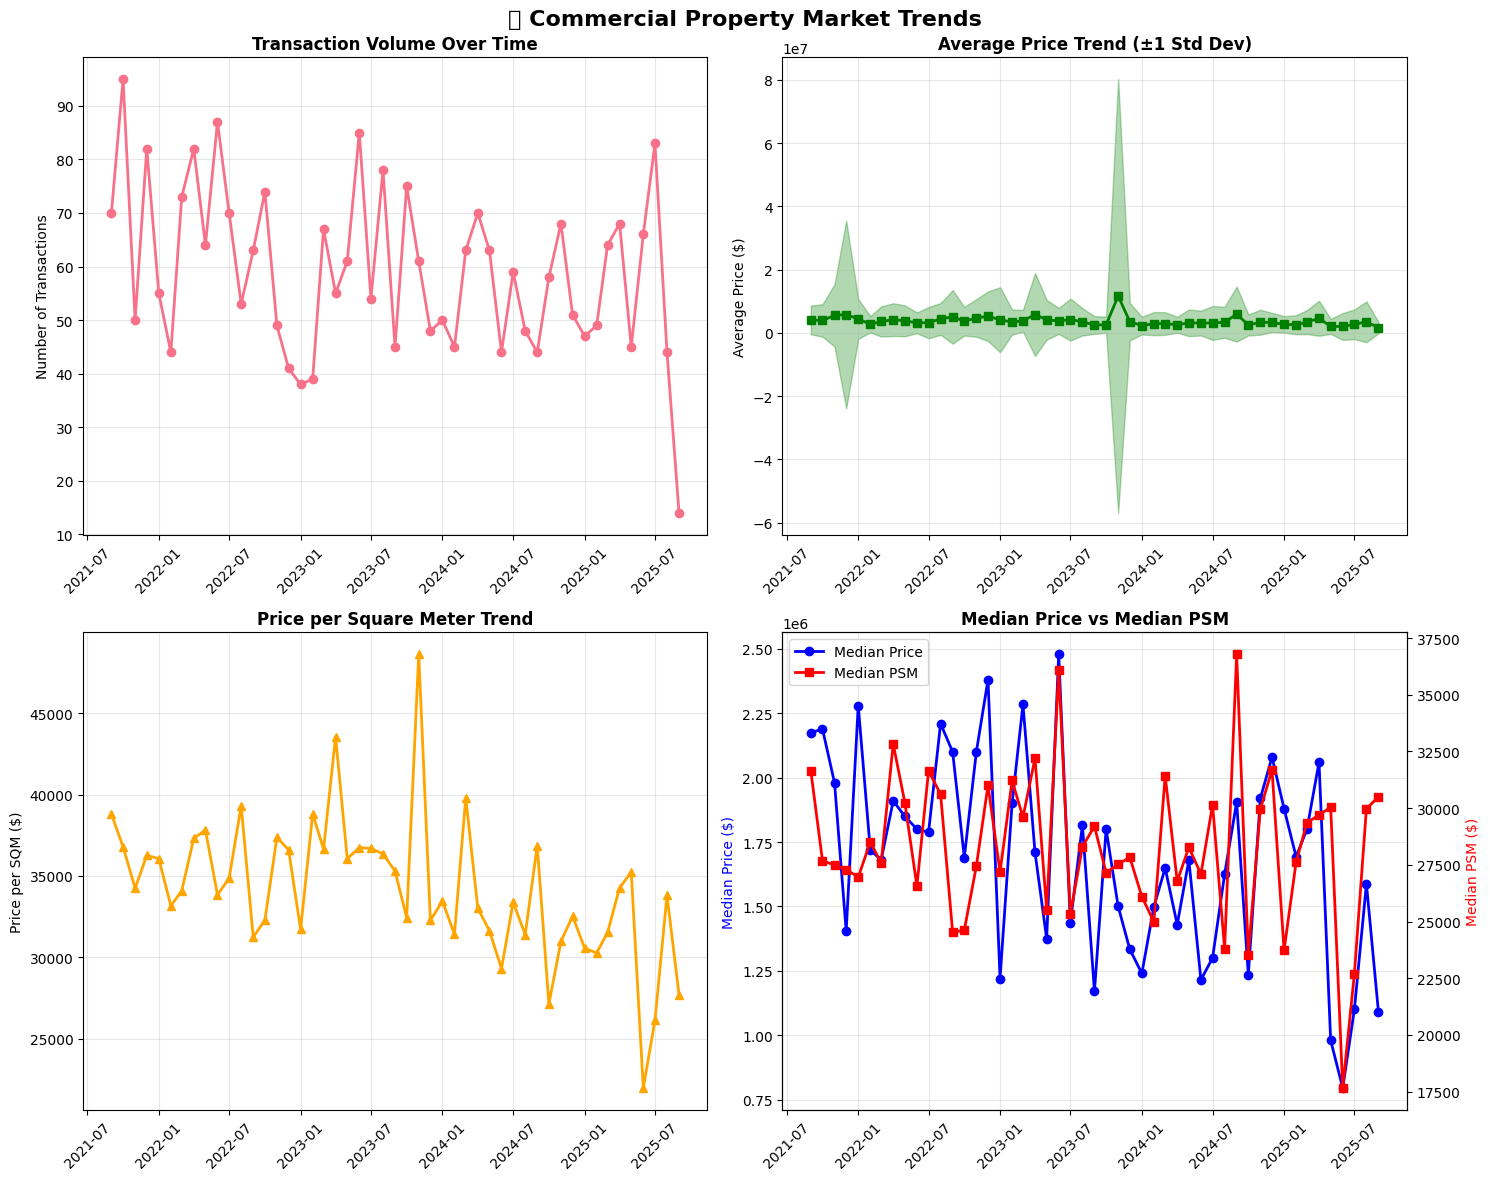


📊 SUMMARY STATISTICS
Total Transactions: 2,901
Date Range: 2021-09 to 2025-09
Average Price: $3,786,430
Median Price: $1,680,000
Average PSM: $34,356
Median PSM: $28,163
Year-over-Year Growth: -72.6%


In [53]:
# -------------------------
# COMMERCIAL MARKET TREND VISUALIZATION
# -------------------------

import matplotlib.pyplot as plt
import seaborn as sns

def plot_commercial_trends_fixed(df_commercial):
    """Commercial market trends matching industrial visualization structure"""
    
    # Set up plotting style
    plt.style.use('default')
    sns.set_palette("husl")
    
    # Filter data if specific area/type requested (same as industrial)
    trend_df = df_commercial.copy()
    
    # Parse commercial dates - handle abbreviated month-year format like "Sept-25"
    def parse_commercial_date(date_str):
        try:
            # Handle formats like "Sept-25", "Aug-25", etc.
            if isinstance(date_str, str) and '-' in date_str:
                month_year = date_str.split('-')
                if len(month_year) == 2:
                    month_abbr = month_year[0]
                    year = '20' + month_year[1]  # Convert "25" to "2025"
                    
                    # Map abbreviated months to full names
                    month_map = {
                        'Jan': '01', 'Feb': '02', 'Mar': '03', 'Apr': '04',
                        'May': '05', 'Jun': '06', 'Jul': '07', 'Aug': '08',
                        'Sep': '09', 'Sept': '09', 'Oct': '10', 'Nov': '11', 'Dec': '12'
                    }
                    
                    if month_abbr in month_map:
                        return pd.to_datetime(f"{year}-{month_map[month_abbr]}-01")
            return pd.to_datetime(date_str, errors='coerce')
        except:
            return pd.NaT
    
    # Convert contract_date to datetime
    trend_df['contract_date'] = trend_df['contract_date'].apply(parse_commercial_date)
    trend_df = trend_df.dropna(subset=['contract_date'])
    
    # Group by month and calculate statistics (same as industrial)
    monthly_stats = trend_df.groupby(trend_df['contract_date'].dt.to_period('M')).agg({
        'price': ['count', 'mean', 'median', 'std'],
        '$psm': ['mean', 'median']
    }).round(2)
    
    # Flatten column names
    monthly_stats.columns = ['_'.join(col).strip() for col in monthly_stats.columns]
    monthly_stats = monthly_stats.reset_index()
    monthly_stats['contract_date'] = monthly_stats['contract_date'].dt.to_timestamp()
    
    # Create subplots (same structure as industrial)
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('🏢 Commercial Property Market Trends', 
                 fontsize=16, fontweight='bold')
    
    # 1. Transaction Volume
    axes[0,0].plot(monthly_stats['contract_date'], monthly_stats['price_count'], 
                   marker='o', linewidth=2, markersize=6)
    axes[0,0].set_title('Transaction Volume Over Time', fontweight='bold')
    axes[0,0].set_ylabel('Number of Transactions')
    axes[0,0].grid(True, alpha=0.3)
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # 2. Average Price Trend
    axes[0,1].plot(monthly_stats['contract_date'], monthly_stats['price_mean'], 
                   marker='s', linewidth=2, markersize=6, color='green')
    axes[0,1].fill_between(monthly_stats['contract_date'], 
                          monthly_stats['price_mean'] - monthly_stats['price_std'],
                          monthly_stats['price_mean'] + monthly_stats['price_std'],
                          alpha=0.3, color='green')
    axes[0,1].set_title('Average Price Trend (±1 Std Dev)', fontweight='bold')
    axes[0,1].set_ylabel('Average Price ($)')
    axes[0,1].grid(True, alpha=0.3)
    axes[0,1].tick_params(axis='x', rotation=45)
    
    # 3. Price per Square Meter
    axes[1,0].plot(monthly_stats['contract_date'], monthly_stats['$psm_mean'], 
                   marker='^', linewidth=2, markersize=6, color='orange')
    axes[1,0].set_title('Price per Square Meter Trend', fontweight='bold')
    axes[1,0].set_ylabel('Price per SQM ($)')
    axes[1,0].grid(True, alpha=0.3)
    axes[1,0].tick_params(axis='x', rotation=45)
    
    # 4. Median Price vs Median PSM
    ax2 = axes[1,1].twinx()
    line1 = axes[1,1].plot(monthly_stats['contract_date'], monthly_stats['price_median'], 
                          marker='o', linewidth=2, markersize=6, color='blue', label='Median Price')
    line2 = ax2.plot(monthly_stats['contract_date'], monthly_stats['$psm_median'], 
                    marker='s', linewidth=2, markersize=6, color='red', label='Median PSM')
    
    axes[1,1].set_title('Median Price vs Median PSM', fontweight='bold')
    axes[1,1].set_ylabel('Median Price ($)', color='blue')
    ax2.set_ylabel('Median PSM ($)', color='red')
    axes[1,1].grid(True, alpha=0.3)
    axes[1,1].tick_params(axis='x', rotation=45)
    
    # Combine legends
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    axes[1,1].legend(lines, labels, loc='upper left')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics (same format as industrial)
    print(f"\n📊 SUMMARY STATISTICS")
    print(f"{'='*50}")
    print(f"Total Transactions: {len(trend_df):,}")
    print(f"Date Range: {trend_df['contract_date'].min().strftime('%Y-%m')} to {trend_df['contract_date'].max().strftime('%Y-%m')}")
    print(f"Average Price: ${trend_df['price'].mean():,.0f}")
    print(f"Median Price: ${trend_df['price'].median():,.0f}")
    print(f"Average PSM: ${trend_df['$psm'].mean():,.0f}")
    print(f"Median PSM: ${trend_df['$psm'].median():,.0f}")
    
    # Calculate year-over-year growth
    if len(monthly_stats) >= 12:
        latest_avg = monthly_stats['price_mean'].iloc[-1]
        year_ago_avg = monthly_stats['price_mean'].iloc[-13] if len(monthly_stats) >= 13 else monthly_stats['price_mean'].iloc[0]
        yoy_growth = ((latest_avg - year_ago_avg) / year_ago_avg) * 100
        print(f"Year-over-Year Growth: {yoy_growth:+.1f}%")
    
    return monthly_stats

# Plot commercial market trends (matching industrial structure)
print("🏢 COMMERCIAL PROPERTY MARKET TRENDS")
print("="*60)
commercial_trends = plot_commercial_trends_fixed(df_commercial_clean)


In [54]:
# -------------------------
# SPECIFIC COMMERCIAL MARKET ANALYSIS
# -------------------------

def analyze_specific_commercial_markets(df_commercial):
    """Analyze specific commercial property types and areas"""
    
    print("🏪 SPECIFIC COMMERCIAL MARKET ANALYSIS")
    print("="*50)
    
    # Property type analysis
    if 'property_type' in df_commercial.columns:
        print(f"\n📊 COMMERCIAL PROPERTY TYPE DISTRIBUTION")
        print("="*45)
        property_counts = df_commercial['property_type'].value_counts()
        print(property_counts)
        
        # Price analysis by property type
        print(f"\n💰 COMMERCIAL PRICE ANALYSIS BY PROPERTY TYPE")
        print("="*50)
        if 'price' in df_commercial.columns and '$psm' in df_commercial.columns:
            price_analysis = df_commercial.groupby('property_type').agg({
                'price': ['count', 'mean', 'median', 'std'],
                '$psm': ['mean', 'median']
            }).round(2)
            print(price_analysis)
    
    # Postal district analysis
    if 'postal_district' in df_commercial.columns:
        print(f"\n📍 TOP COMMERCIAL POSTAL DISTRICTS")
        print("="*40)
        district_counts = df_commercial['postal_district'].value_counts().head(10)
        print(district_counts)
        
        # Price analysis by postal district
        print(f"\n🏙️ COMMERCIAL PRICE ANALYSIS BY POSTAL DISTRICT")
        print("="*50)
        if 'price' in df_commercial.columns and '$psm' in df_commercial.columns:
            district_price_analysis = df_commercial.groupby('postal_district').agg({
                'price': ['count', 'mean', 'median'],
                '$psm': ['mean', 'median']
            }).round(2)
            # Show top 10 districts by transaction count
            top_districts = df_commercial['postal_district'].value_counts().head(10).index
            print(district_price_analysis.loc[top_districts])
    
    # Area analysis
    if 'area' in df_commercial.columns:
        print(f"\n📏 COMMERCIAL AREA ANALYSIS")
        print("="*30)
        print(f"Average Area: {df_commercial['area'].mean():.1f} sqm")
        print(f"Median Area: {df_commercial['area'].median():.1f} sqm")
        print(f"Min Area: {df_commercial['area'].min():.1f} sqm")
        print(f"Max Area: {df_commercial['area'].max():.1f} sqm")
        
        # Area distribution
        print(f"\n📊 COMMERCIAL AREA DISTRIBUTION")
        print("="*35)
        area_bins = [0, 50, 100, 200, 500, 1000, float('inf')]
        area_labels = ['0-50', '51-100', '101-200', '201-500', '501-1000', '1000+']
        df_commercial['area_range'] = pd.cut(df_commercial['area'], bins=area_bins, labels=area_labels, right=False)
        area_distribution = df_commercial['area_range'].value_counts().sort_index()
        print(area_distribution)
    
    # Market comparison table
    print(f"\n📊 COMPREHENSIVE COMMERCIAL MARKET COMPARISON")
    print("="*55)
    
    if 'property_type' in df_commercial.columns and 'price' in df_commercial.columns and '$psm' in df_commercial.columns:
        comparison_data = []
        for prop_type in df_commercial['property_type'].unique():
            prop_data = df_commercial[df_commercial['property_type'] == prop_type]
            if len(prop_data) > 0:
                comparison_data.append({
                    'Property Type': prop_type,
                    'Count': len(prop_data),
                    'Avg Price': f"${prop_data['price'].mean():,.0f}",
                    'Median Price': f"${prop_data['price'].median():,.0f}",
                    'Avg PSM': f"${prop_data['$psm'].mean():,.0f}",
                    'Median PSM': f"${prop_data['$psm'].median():,.0f}",
                    'Avg Area': f"{prop_data['area'].mean():.1f} sqm" if 'area' in prop_data.columns else "N/A"
                })
        
        comparison_df = pd.DataFrame(comparison_data)
        print(comparison_df.to_string(index=False))
    
    return True

# Run specific commercial market analysis
analyze_specific_commercial_markets(df_commercial_clean)


🏪 SPECIFIC COMMERCIAL MARKET ANALYSIS

📊 COMMERCIAL PROPERTY TYPE DISTRIBUTION
property_type
Office        1314
Retail        1044
Shop House     543
Name: count, dtype: int64

💰 COMMERCIAL PRICE ANALYSIS BY PROPERTY TYPE
              price                                          $psm         
              count        mean     median          std      mean   median
property_type                                                             
Office         1314  3562372.21  1390000.0  17245694.14  26268.56  22774.5
Retail         1044  1956881.52  1151500.0   2977048.41  33612.41  30013.0
Shop House      543  7846208.45  5900000.0   6614182.41  55355.75  48293.0

📍 TOP COMMERCIAL POSTAL DISTRICTS
postal_district
1     454
7     395
14    305
8     292
9     234
15    196
6     147
2     144
3     119
12    100
Name: count, dtype: int64

🏙️ COMMERCIAL PRICE ANALYSIS BY POSTAL DISTRICT
                price                             $psm         
                count        mean     

True

In [55]:
# -------------------------
# GEOSPATIAL FEATURES FOR COMMERCIAL PROPERTY PREDICTION
# -------------------------

def add_commercial_geospatial_features(df):
    """Add geospatial features specifically for commercial properties using geopandas and shapely"""
    
    # Create a copy to avoid modifying original
    geo_df = df.copy()
    
    # Define key Singapore landmarks for commercial property analysis
    cbd_point = Point(103.851959, 1.283088)  # Raffles Place (CBD) - most important for commercial
    changi_point = Point(103.9894, 1.3644)   # Changi Airport - business travel hub
    jurong_point = Point(103.7414, 1.2966)   # Jurong East (Business park)
    marina_point = Point(103.8607, 1.2814)   # Marina Bay - financial district
    orchard_point = Point(103.8322, 1.3048)  # Orchard Road - retail hub
    
    # Add dummy coordinates for demonstration (in real scenario, you'd have lat/lon)
    # For commercial properties, we'll use postal district as proxy for location
    np.random.seed(42)  # For reproducible results
    
    # Generate approximate coordinates based on postal district
    geo_df['lat'] = geo_df['postal_district'].apply(lambda x: 1.3 + (x % 10) * 0.05 + np.random.normal(0, 0.01))
    geo_df['lon'] = geo_df['postal_district'].apply(lambda x: 103.7 + (x % 10) * 0.05 + np.random.normal(0, 0.01))
    
    # Create geometry column first
    geo_df['geometry'] = gpd.points_from_xy(geo_df['lon'], geo_df['lat'])
    
    # Now create GeoDataFrame with geometry column
    geo_df = gpd.GeoDataFrame(geo_df, geometry='geometry', crs="EPSG:4326")
    
    # Convert to projected CRS for accurate distance calculations
    geo_df = geo_df.to_crs(epsg=3414)  # Singapore projected CRS
    
    # Convert landmark points to same CRS
    landmarks = gpd.GeoSeries([cbd_point, changi_point, jurong_point, marina_point, orchard_point], crs="EPSG:4326").to_crs(epsg=3414)
    
    # Calculate distances to key commercial landmarks
    geo_df['dist_cbd_km'] = geo_df.geometry.distance(landmarks.iloc[0]) / 1000
    geo_df['dist_airport_km'] = geo_df.geometry.distance(landmarks.iloc[1]) / 1000
    geo_df['dist_jurong_km'] = geo_df.geometry.distance(landmarks.iloc[2]) / 1000
    geo_df['dist_marina_km'] = geo_df.geometry.distance(landmarks.iloc[3]) / 1000
    geo_df['dist_orchard_km'] = geo_df.geometry.distance(landmarks.iloc[4]) / 1000
    
    # Add commercial-specific region classification
    geo_df['is_cbd_nearby'] = (geo_df['dist_cbd_km'] <= 3).astype(int)  # Tighter radius for commercial
    geo_df['is_marina_nearby'] = (geo_df['dist_marina_km'] <= 5).astype(int)
    geo_df['is_orchard_nearby'] = (geo_df['dist_orchard_km'] <= 3).astype(int)
    geo_df['is_airport_nearby'] = (geo_df['dist_airport_km'] <= 15).astype(int)  # Wider for business travel
    geo_df['is_business_hub'] = (geo_df['dist_jurong_km'] <= 10).astype(int)
    
    # Commercial property premium zones
    geo_df['is_premium_location'] = (
        (geo_df['is_cbd_nearby'] == 1) | 
        (geo_df['is_marina_nearby'] == 1) | 
        (geo_df['is_orchard_nearby'] == 1)
    ).astype(int)
    
    print("🏢 COMMERCIAL GEOSPATIAL FEATURES ADDED:")
    print(f"✅ Distance to CBD: {geo_df['dist_cbd_km'].mean():.1f} km (avg)")
    print(f"✅ Distance to Marina Bay: {geo_df['dist_marina_km'].mean():.1f} km (avg)")
    print(f"✅ Distance to Orchard: {geo_df['dist_orchard_km'].mean():.1f} km (avg)")
    print(f"✅ Distance to Airport: {geo_df['dist_airport_km'].mean():.1f} km (avg)")
    print(f"✅ Distance to Jurong: {geo_df['dist_jurong_km'].mean():.1f} km (avg)")
    print(f"✅ Properties near CBD: {geo_df['is_cbd_nearby'].sum()} ({geo_df['is_cbd_nearby'].mean()*100:.1f}%)")
    print(f"✅ Properties near Marina: {geo_df['is_marina_nearby'].sum()} ({geo_df['is_marina_nearby'].mean()*100:.1f}%)")
    print(f"✅ Properties near Orchard: {geo_df['is_orchard_nearby'].sum()} ({geo_df['is_orchard_nearby'].mean()*100:.1f}%)")
    print(f"✅ Properties in Premium Locations: {geo_df['is_premium_location'].sum()} ({geo_df['is_premium_location'].mean()*100:.1f}%)")
    
    return geo_df

# Add geospatial features to the commercial dataset
print("🏢 ADDING GEOSPATIAL FEATURES FOR COMMERCIAL PROPERTY PREDICTION")
print("="*75)
df_commercial_with_geo = add_commercial_geospatial_features(df_commercial_clean)

# Show sample of commercial geospatial features
print(f"\n📊 SAMPLE COMMERCIAL GEOSPATIAL DATA:")
print("="*50)
commercial_geo_sample = df_commercial_with_geo[['property_type', 'price', 'dist_cbd_km', 'dist_marina_km', 'dist_orchard_km', 'is_cbd_nearby', 'is_premium_location']].head()
display(commercial_geo_sample)


🏢 ADDING GEOSPATIAL FEATURES FOR COMMERCIAL PROPERTY PREDICTION
🏢 COMMERCIAL GEOSPATIAL FEATURES ADDED:
✅ Distance to CBD: 32.9 km (avg)
✅ Distance to Marina Bay: 33.0 km (avg)
✅ Distance to Orchard: 31.1 km (avg)
✅ Distance to Airport: 28.7 km (avg)
✅ Distance to Jurong: 34.6 km (avg)
✅ Properties near CBD: 0 (0.0%)
✅ Properties near Marina: 0 (0.0%)
✅ Properties near Orchard: 0 (0.0%)
✅ Properties in Premium Locations: 0 (0.0%)

📊 SAMPLE COMMERCIAL GEOSPATIAL DATA:


,property_type,price,dist_cbd_km,dist_marina_km,dist_orchard_km,is_cbd_nearby,is_premium_location
0,Shop House,1400000.0,25.013770,25.026899,23.236164,0,0
1,Shop House,6350000.0,45.736316,45.455903,44.748854,0,0
2,Shop House,2000000.0,46.975141,46.684794,46.016743,0,0
3,Shop House,3850000.0,32.532389,32.450612,30.979198,0,0
4,Shop House,4200000.0,16.156948,17.143745,13.899801,0,0


In [ ]:
# -------------------------
# FRONTEND INPUT TO ML PREDICTION SYSTEM
# -------------------------
# Copy this code into a new cell in your machinelearning.ipynb notebook
# This system takes property data from compareprediction.js/priceprediction.js
# and generates ML predictions for PropertyCard.js

import difflib

def find_best_matching_address(frontend_address, all_addresses, threshold=0.7):
    """Find the best matching address from ML dataset based on frontend input"""
    
    if not frontend_address:
        return None, 0
    
    # Clean the frontend address
    frontend_clean = frontend_address.lower().strip()
    
    best_match = None
    best_score = 0
    
    for addr in all_addresses:
        # Try matching against different address components
        street_clean = addr['street_name'].lower()
        project_clean = addr['project_name'].lower() if addr['project_name'] != 'N.A.' else ''
        full_clean = addr['full_address'].lower()
        
        # Calculate similarity scores
        street_score = difflib.SequenceMatcher(None, frontend_clean, street_clean).ratio()
        project_score = difflib.SequenceMatcher(None, frontend_clean, project_clean).ratio() if project_clean else 0
        full_score = difflib.SequenceMatcher(None, frontend_clean, full_clean).ratio()
        
        # Take the best score
        max_score = max(street_score, project_score, full_score)
        
        if max_score > best_score and max_score >= threshold:
            best_score = max_score
            best_match = addr
    
    return best_match, best_score

def convert_frontend_to_ml_format(frontend_property_data):
    """Convert frontend property data to ML prediction format"""
    
    # Extract data from frontend format (as it comes from compareprediction.js)
    property_type = frontend_property_data.get('propertyType', '')
    address = frontend_property_data.get('address', '')
    floor_area = frontend_property_data.get('floorArea', '')
    level = frontend_property_data.get('level', '')
    unit = frontend_property_data.get('unit', '')
    
    # Convert floor area from sq ft to sqm (frontend uses sq ft, ML uses sqm)
    try:
        area_sqm = float(floor_area.replace(',', '')) * 0.092903  # Convert sq ft to sqm
    except (ValueError, AttributeError):
        area_sqm = 100.0  # Default fallback
    
    return {
        'property_type': property_type,
        'address': address,
        'area_sqm': area_sqm,
        'level': level,
        'unit': unit
    }

def predict_from_frontend_input(frontend_property_data, all_addresses, df_industrial, df_commercial=None):
    """Generate ML prediction from frontend property input data"""
    
    print(f"🔄 CONVERTING FRONTEND INPUT TO ML PREDICTION")
    print("="*60)
    
    # Convert frontend data to ML format
    ml_data = convert_frontend_to_ml_format(frontend_property_data)
    
    print(f"📝 Frontend Input Data:")
    print(f"   Property Type: {ml_data['property_type']}")
    print(f"   Address: {ml_data['address']}")
    print(f"   Area: {ml_data['area_sqm']:.1f} sqm ({frontend_property_data.get('floorArea', 'N/A')} sq ft)")
    print(f"   Level: {ml_data['level']}")
    print(f"   Unit: {ml_data['unit']}")
    print()
    
    # Find best matching address in ML dataset
    print(f"🔍 SEARCHING FOR MATCHING ADDRESS IN ML DATASET...")
    best_match, match_score = find_best_matching_address(ml_data['address'], all_addresses)
    
    if best_match:
        print(f"✅ Found matching address with {match_score:.1%} similarity:")
        print(f"   ML Dataset Address: {best_match['full_address']}")
        print(f"   Planning Area: {best_match['planning_area']}")
        print(f"   Property Category: {best_match['category']}")
        print()
        
        # Generate prediction using the matched address
        property_data, comparison_data = predict_for_propertycard(
            selected_address=best_match,
            property_type=ml_data['property_type'],
            area=ml_data['area_sqm'],
            df_industrial=df_industrial,
            df_commercial=df_commercial
        )
        
        # Update property data with frontend input details
        property_data['address'] = ml_data['address']  # Use original frontend address
        property_data['floorArea'] = f"{frontend_property_data.get('floorArea', 'N/A')} sq ft"
        property_data['level'] = ml_data['level']
        property_data['unit'] = ml_data['unit']
        
        return property_data, comparison_data, best_match
        
    else:
        print(f"❌ No matching address found in ML dataset")
        print(f"   Searched for: {ml_data['address']}")
        print(f"   Available addresses: {len(all_addresses)}")
        print()
        
        # Try to find by property type only (fallback)
        print(f"🔄 FALLBACK: Searching by property type only...")
        matching_type_addresses = [addr for addr in all_addresses if ml_data['property_type'].lower() in addr['property_type'].lower()]
        
        if matching_type_addresses:
            print(f"✅ Found {len(matching_type_addresses)} addresses with matching property type")
            # Use the first matching address
            fallback_address = matching_type_addresses[0]
            
            property_data, comparison_data = predict_for_propertycard(
                selected_address=fallback_address,
                property_type=ml_data['property_type'],
                area=ml_data['area_sqm'],
                df_industrial=df_industrial,
                df_commercial=df_commercial
            )
            
            # Update with frontend data
            property_data['address'] = ml_data['address']
            property_data['floorArea'] = f"{frontend_property_data.get('floorArea', 'N/A')} sq ft"
            property_data['level'] = ml_data['level']
            property_data['unit'] = ml_data['unit']
            
            return property_data, comparison_data, fallback_address
        else:
            print(f"❌ No addresses found with matching property type")
            return None, None, None

# Example usage function
def example_frontend_to_ml_prediction():
    """Example of how to use the frontend-to-ML prediction system"""
    
    # Example frontend property data (as it would come from compareprediction.js)
    example_frontend_property = {
        'propertyType': 'Multiple-User Factory',
        'address': 'Woodlands Industrial Park E9, Singapore',
        'floorArea': '1500',
        'level': 'Ground Floor',
        'unit': 'A-01'
    }
    
    print("🏠 FRONTEND TO ML PREDICTION SYSTEM")
    print("="*60)
    print("This system takes property data from your frontend components")
    print("(compareprediction.js, priceprediction.js) and generates")
    print("ML predictions for PropertyCard.js display.")
    print()
    print("Example frontend property data:")
    for key, value in example_frontend_property.items():
        print(f"  {key}: {value}")
    print()
    
    # Generate prediction from frontend input
    property_data, comparison_data, matched_address = predict_from_frontend_input(
        frontend_property_data=example_frontend_property,
        all_addresses=all_addresses,  # This should be defined in your notebook
        df_industrial=df,  # This should be your industrial dataset
        df_commercial=df_commercial_clean if 'df_commercial_clean' in globals() else None
    )
    
    if property_data and comparison_data:
        print("\n✅ SUCCESS: Property Card data generated!")
        print("This data can be directly used in your PropertyCard.js component:")
        print()
        print("Property Data:")
        for key, value in property_data.items():
            print(f"  {key}: {value}")
        print()
        print("Comparison Data (key fields):")
        print(f"  estimatedSalesPrice: {comparison_data['estimatedSalesPrice']}")
        print(f"  estimatedRentalPrice: {comparison_data['estimatedRentalPrice']}")
        print(f"  marketTrend: {comparison_data['marketTrend']}")
        print(f"  historicalTransactions: {len(comparison_data['historicalTransactions'])} transactions")
        
        return property_data, comparison_data
    else:
        print("\n❌ FAILED: Could not generate prediction")
        return None, None




🎯 USAGE INSTRUCTIONS:

1. Copy this entire code into a new cell in your machinelearning.ipynb notebook

2. Make sure you have the following variables defined in your notebook:
   - all_addresses (from the address selection system)
   - df (your industrial dataset)
   - df_commercial_clean (your commercial dataset, if available)

3. Use the system like this:

   # Example property data from your frontend
   frontend_property = {
       'propertyType': 'Multiple-User Factory',
       'address': 'Woodlands Industrial Park E9, Singapore',
       'floorArea': '1500',
       'level': 'Ground Floor',
       'unit': 'A-01'
   }
   
   # Generate ML prediction
   property_data, comparison_data, matched_address = predict_from_frontend_input(
       frontend_property_data=frontend_property,
       all_addresses=all_addresses,
       df_industrial=df,
       df_commercial=df_commercial_clean
   )
   
   # Use the returned data in your PropertyCard component
   # property_data and comparison_data 